In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

pd.options.display.max_columns = 100

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor as RF

In [63]:
data = pd.read_csv("train.csv")

In [418]:
def changeParam (findParam,changeParam,dataParam,df):
    df.loc[df[dataParam]== findParam,dataParam] = changeParam
    
def HealthcareFill(df):
    df.loc[:, ['Healthcare_1']] = df['Healthcare_1'].fillna(df['Healthcare_1'].mean())
    
def LifeSquareFill(df):
    df.loc[:, ['LifeSquare']] = df['LifeSquare'].fillna(df['LifeSquare'].mean()) 
    
def normFloorNull(df):
    year_df = df.loc[(df['Floor']>df['HouseFloor']) ,['HouseYear']]
    for year in  np.unique(year_df[['HouseYear']].values):
        df.loc[(df['Floor']>df['HouseFloor']) &(df['HouseYear'] == year)  ,'HouseFloor'] = \
            df.loc[(df['Floor']>df['HouseFloor']) &(df['HouseYear'] == year)  ,'Floor'].mean()
        
def normFloorNotNull(df):
    df.loc[(df['Floor']>df['HouseFloor']) & (df['HouseFloor'] != 0),'HouseFloor'] =\
          df.loc[(df['Floor']>df['HouseFloor']) & (df['HouseFloor'] != 0),'Floor']
    
def normFloor(df):
    normFloorNotNull(df)
    normFloorNull(df)
    normFloorNotNull(df)
    
def changetype(df,changeType,column):
    df.loc[:,column] = df[column].astype(changeType)
    
def normSquare(changePar,dataParam,df):
    room_df = df.loc[df[dataParam]>df[dataParam].mean()*3 ,[changePar]]
    
    for room in np.unique(room_df[[changePar]].values):
        df.loc[(df[dataParam]>df[dataParam].mean()*3) & (df[changePar] == room),dataParam] = \
            df.loc[df[changePar] == room,dataParam].mean()*1.5
        
def add_mean_price(df, mean_price1=mean_price1, mean_price2=mean_price2):
    df = pd.merge(df,mean_price1,on=['DistrictId','Rooms'],how='left')
    df = pd.merge(df,mean_price2,on='Rooms',how='left')
    df.loc[df['mean_price_2'].isnull(),'mean_price_2'] = mean_price2.loc[mean_price2['Rooms']==4,'mean_price_2'].values[0]
    df.loc[df['mean_price_1'].isnull(),'mean_price_1'] = df['mean_price_2']
    return df

def FinalFunction(df):
    changeParam(10,2,'Rooms',df)
    changeParam(19,1,'Rooms',df)
    changeParam(6,2,'Rooms',df)
    changeParam(20052011,2008,'HouseYear',df)
    changeParam(4968,1968,'HouseYear',df)
    HealthcareFill(df)
    LifeSquareFill(df)
    normFloor(df)
    changetype(df,'int64','Rooms')
    changetype(df,'int64','Floor')
    changetype(df,'int64','HouseFloor')
    normSquare('Rooms','Square',df)

In [419]:
train,valid = train_test_split(data,test_size=0.3,random_state=42)

In [314]:
# changeParam(10,2,'Rooms',train)
# changeParam(19,1,'Rooms',train)
# changeParam(6,2,'Rooms',train)
# changeParam(20052011,2008,'HouseYear',train)
# changeParam(4968,1968,'HouseYear',train)
# addColumnMeanPrice('Ecology_2','A','Ecology_2_mean_price','Price',train)
# addColumnMeanPrice('Ecology_2','B','Ecology_2_mean_price','Price',train)
# HealthcareFill(train)
# normFloor(train)
# changetype(train,'int64','Rooms')
# changetype(train,'int64','Floor')
# changetype(train,'int64','HouseFloor')
# normSquare('Rooms','Square',train)

In [423]:
mean_price1 = train.groupby(['DistrictId','Rooms'],as_index=False)['Price'].mean()
mean_price1 = mean_price1.rename(columns = {'Price':'mean_price_1'})

mean_price2 = train.groupby('Rooms',as_index=False)['Price'].mean()
mean_price2 = mean_price2.rename(columns = {'Price':'mean_price_2'})

In [421]:
FinalFunction(train)


In [422]:
FinalFunction(valid)

In [424]:
train = add_mean_price(train)
valid =  add_mean_price(valid)

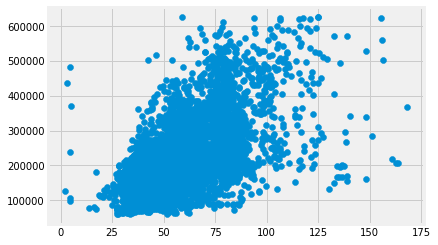

In [441]:
plt.scatter(train['Square'],train['Price'])

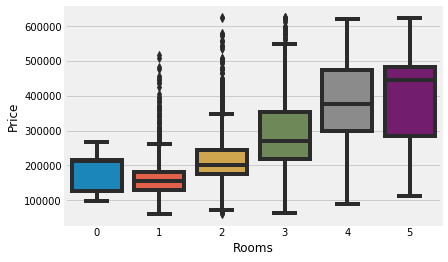

In [442]:
sns.boxplot(train['Rooms'],train['Price'])

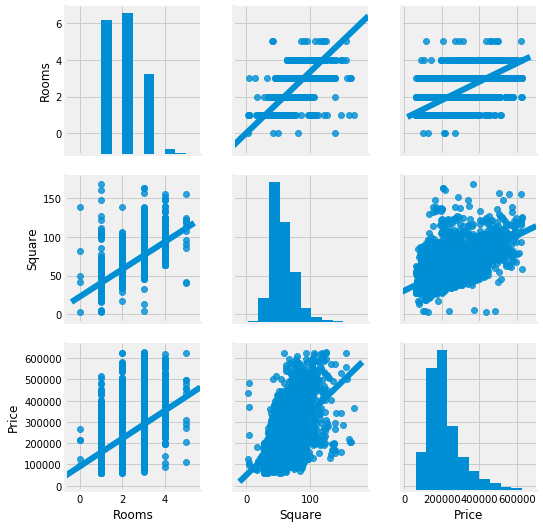

In [443]:
sns.pairplot(train.loc[:,['Rooms','Square','Price']],kind='reg')

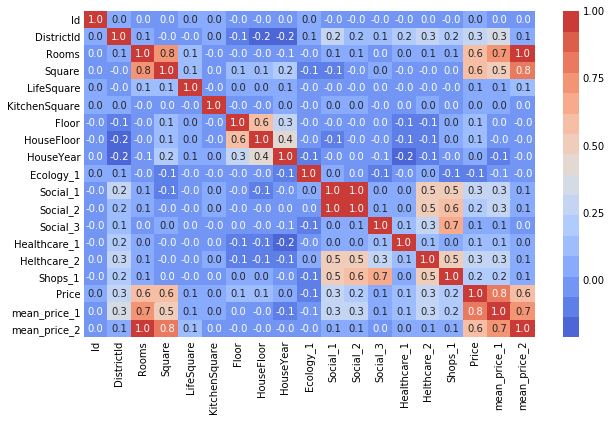

In [444]:
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(train.corr(),annot=True,fmt='.1f',ax=ax,cmap=sns.color_palette('coolwarm', 16))

In [426]:
fts = ['DistrictId', 'Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1','Social_2','Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1','mean_price_2', 'KitchenSquare', 'LifeSquare']
max_depth_arr = np.arange(8, 18)

In [427]:
accuracy_valid = []
accuracy_train = []
for val in max_depth_arr:
    rf = RF(n_estimators=300,max_depth= val,random_state=42,n_jobs=-1,max_features=6)
    rf.fit(train.loc[:,fts],train['Price'])
    pred_train = rf.predict(train.loc[:,fts])
    pred_valid = rf.predict(valid.loc[:,fts])
    acc_train = r2(train['Price'],pred_train)
    acc_valid = r2(valid['Price'],pred_valid)
    accuracy_valid.append(acc_valid)
    accuracy_train.append(acc_train)
    print('max_depth = {} \n\tacc_valid = {} \n\tacc_train = {}\n'.format(val, acc_valid, acc_train))

max_depth = 8 
	acc_valid = 0.6973018940592963 
	acc_train = 0.7952946502806513

max_depth = 9 
	acc_valid = 0.7067612913201062 
	acc_train = 0.8266600296678768

max_depth = 10 
	acc_valid = 0.7150341643118816 
	acc_train = 0.8558639988985594

max_depth = 11 
	acc_valid = 0.720196044524875 
	acc_train = 0.8797576793171241

max_depth = 12 
	acc_valid = 0.7230108425405901 
	acc_train = 0.9009328957554165

max_depth = 13 
	acc_valid = 0.7277198735844367 
	acc_train = 0.91733845694867

max_depth = 14 
	acc_valid = 0.7285708751155716 
	acc_train = 0.9300401772779551

max_depth = 15 
	acc_valid = 0.7315554697401453 
	acc_train = 0.9404053722721852

max_depth = 16 
	acc_valid = 0.7306270780795199 
	acc_train = 0.9482283074280414

max_depth = 17 
	acc_valid = 0.7315025250671422 
	acc_train = 0.9534770877023686



(8, 19)

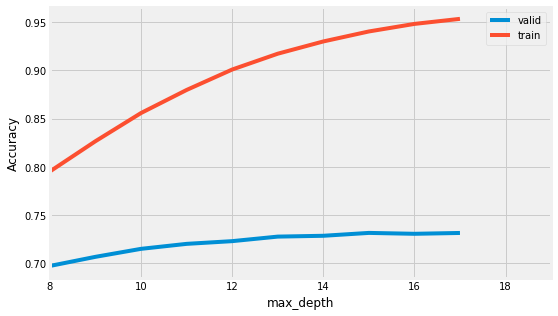

In [428]:
rcParams['figure.figsize'] = 8, 5
plt.plot(max_depth_arr, accuracy_valid)
plt.plot(max_depth_arr, accuracy_train)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend(['valid', 'train'])
plt.xlim(8, 19)

In [429]:
rf = RF(n_estimators=300,max_depth=15,random_state=42,n_jobs=-1,max_features=6)
rf.fit(train.loc[:,fts],train['Price'])
pred_train = rf.predict(train.loc[:,fts])
pred_valid = rf.predict(valid.loc[:,fts])
acc_train = r2(train['Price'],pred_train)
acc_valid = r2(valid['Price'],pred_valid)
print('max_depth = {} \n\tacc_valid = {} \n\tacc_train = {}\n'.format(val, acc_valid, acc_train))

max_depth = 17 
	acc_valid = 0.7315554697401453 
	acc_train = 0.9404053722721852



In [430]:
test = pd.read_csv('test.csv')

In [431]:
FinalFunction(test)

In [432]:
test =  add_mean_price(test)

In [433]:
test['Price'] = rf.predict(test.loc[:,fts])

In [434]:
test['Price']

0       166370.817228
1       228567.831735
2       213293.056146
3       347596.188671
4       142449.895742
5       204375.545344
6       174626.643651
7       217674.157180
8       295885.182378
9       211809.646249
10      273237.893578
11      218557.027150
12      150405.281320
13      185421.718550
14      103210.401461
15      180251.423364
16      374678.827836
17      176998.078385
18      221421.400113
19      241787.652795
20      188965.855470
21      150846.165815
22      230600.814853
23      150957.621891
24      169453.726270
25      180143.801011
26      259179.569414
27      112528.061752
28      196222.399304
29      280801.500429
            ...      
4970    201546.725809
4971    151286.072300
4972    135056.442185
4973    112142.841154
4974    130527.655555
4975    472855.340654
4976    373310.676896
4977    165121.926913
4978    166925.141180
4979    176023.154761
4980    303546.921513
4981    182232.190793
4982     83017.552029
4983    134550.019214
4984    16

In [445]:
test.loc[:,['Id','Price']].to_csv('IKurbakov_predictions.csv',index=False)